In [1]:
from functions import *

In [2]:
 
concrete_compressive_strength = fetch_ucirepo(id=165) 
X = concrete_compressive_strength.data.features 
Y = concrete_compressive_strength.data.targets 


print("*********X*********")  
display(X.head(2)) 
print("*********y*********")
display(Y.head(2)) 

print("Checking NAs fro Xs")
print(X.isna().sum())
print("*******************")
print("Checking NAs fro y")
print(Y.isna().sum())

df= pd.concat([Y,X])

Y = Y.to_numpy().ravel()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


*********X*********


Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0   540.0                 0.0      0.0  162.0               2.5   
1   540.0                 0.0      0.0  162.0               2.5   

   Coarse Aggregate  Fine Aggregate  Age  
0            1040.0           676.0   28  
1            1055.0           676.0   28

*********y*********


Concrete compressive strength
0                          79.99
1                          61.89

Checking NAs fro Xs
Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
dtype: int64
*******************
Checking NAs fro y
Concrete compressive strength    0
dtype: int64


Pair plot

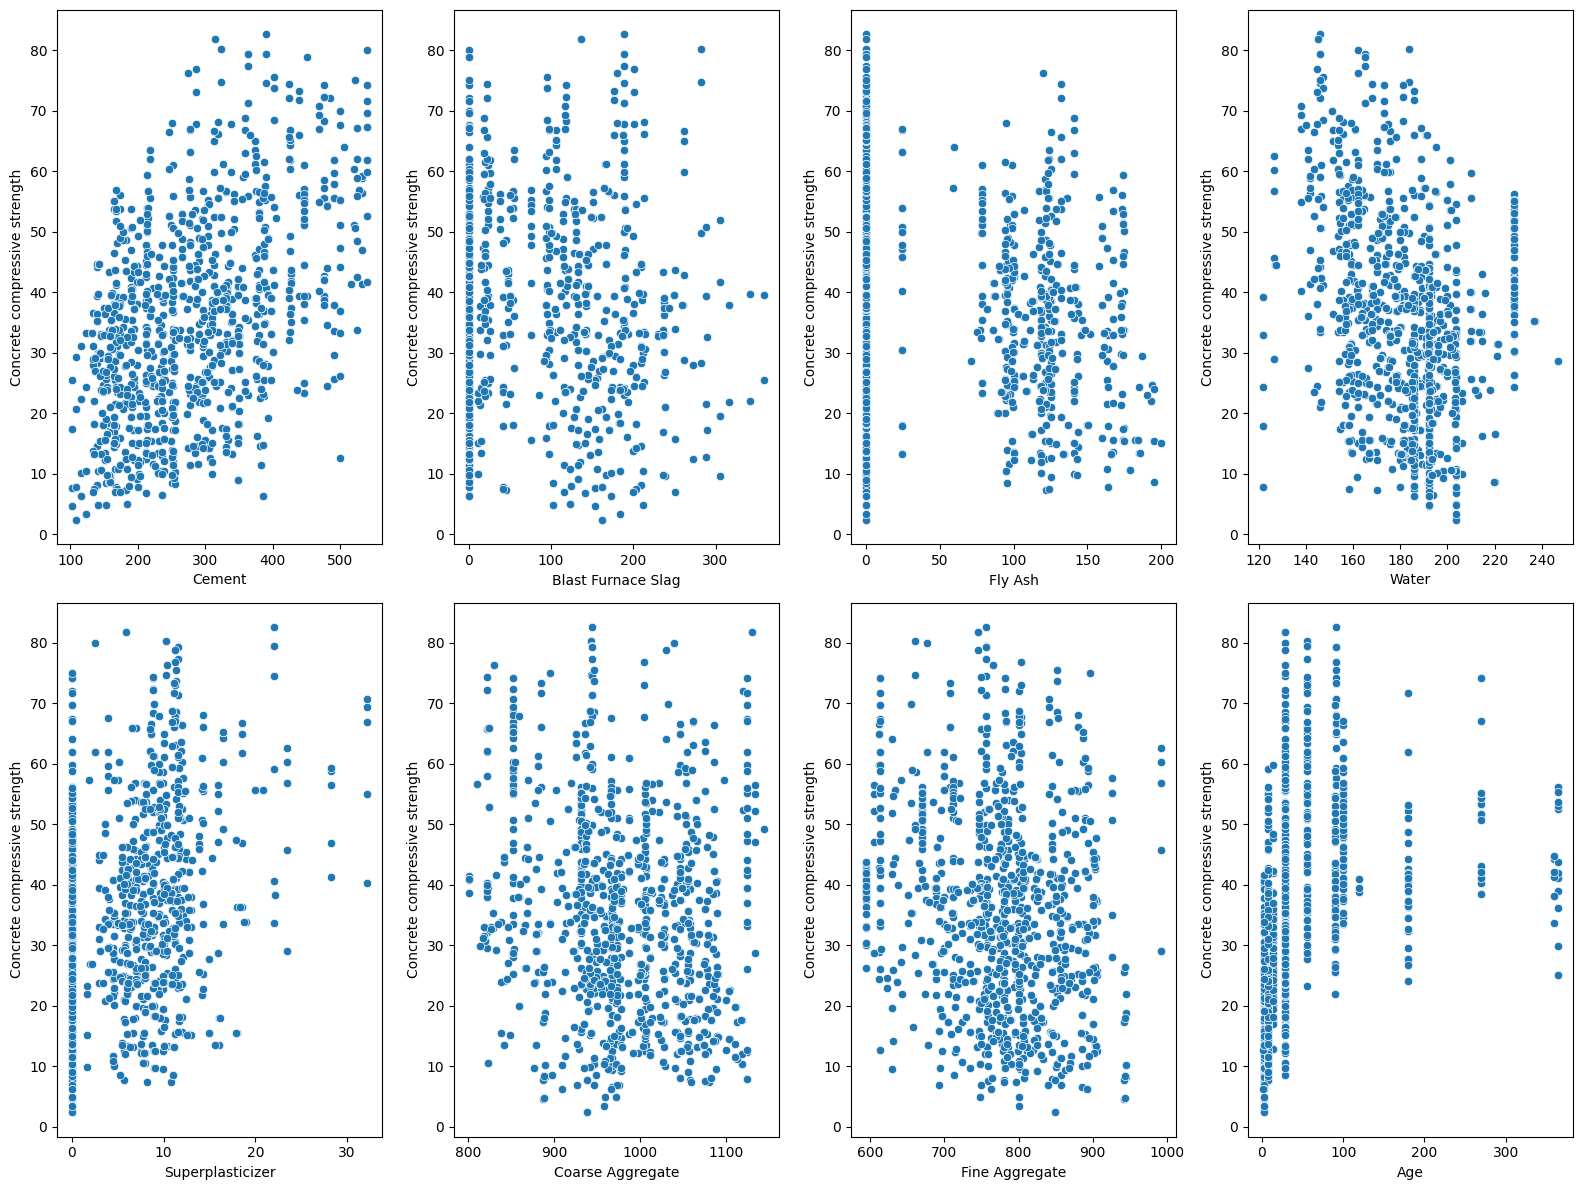

In [3]:
n_cols = 4
n_rows = 2 

# Create subplots with multiple rows and columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))

# Flatten the axes array
axes = axes.flatten()

# Plot each set of three variables against y
for i, column in enumerate(X.columns):
    sns.scatterplot(x=column, y= 'Concrete compressive strength', data=df, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Concrete compressive strength')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Correlation Plot

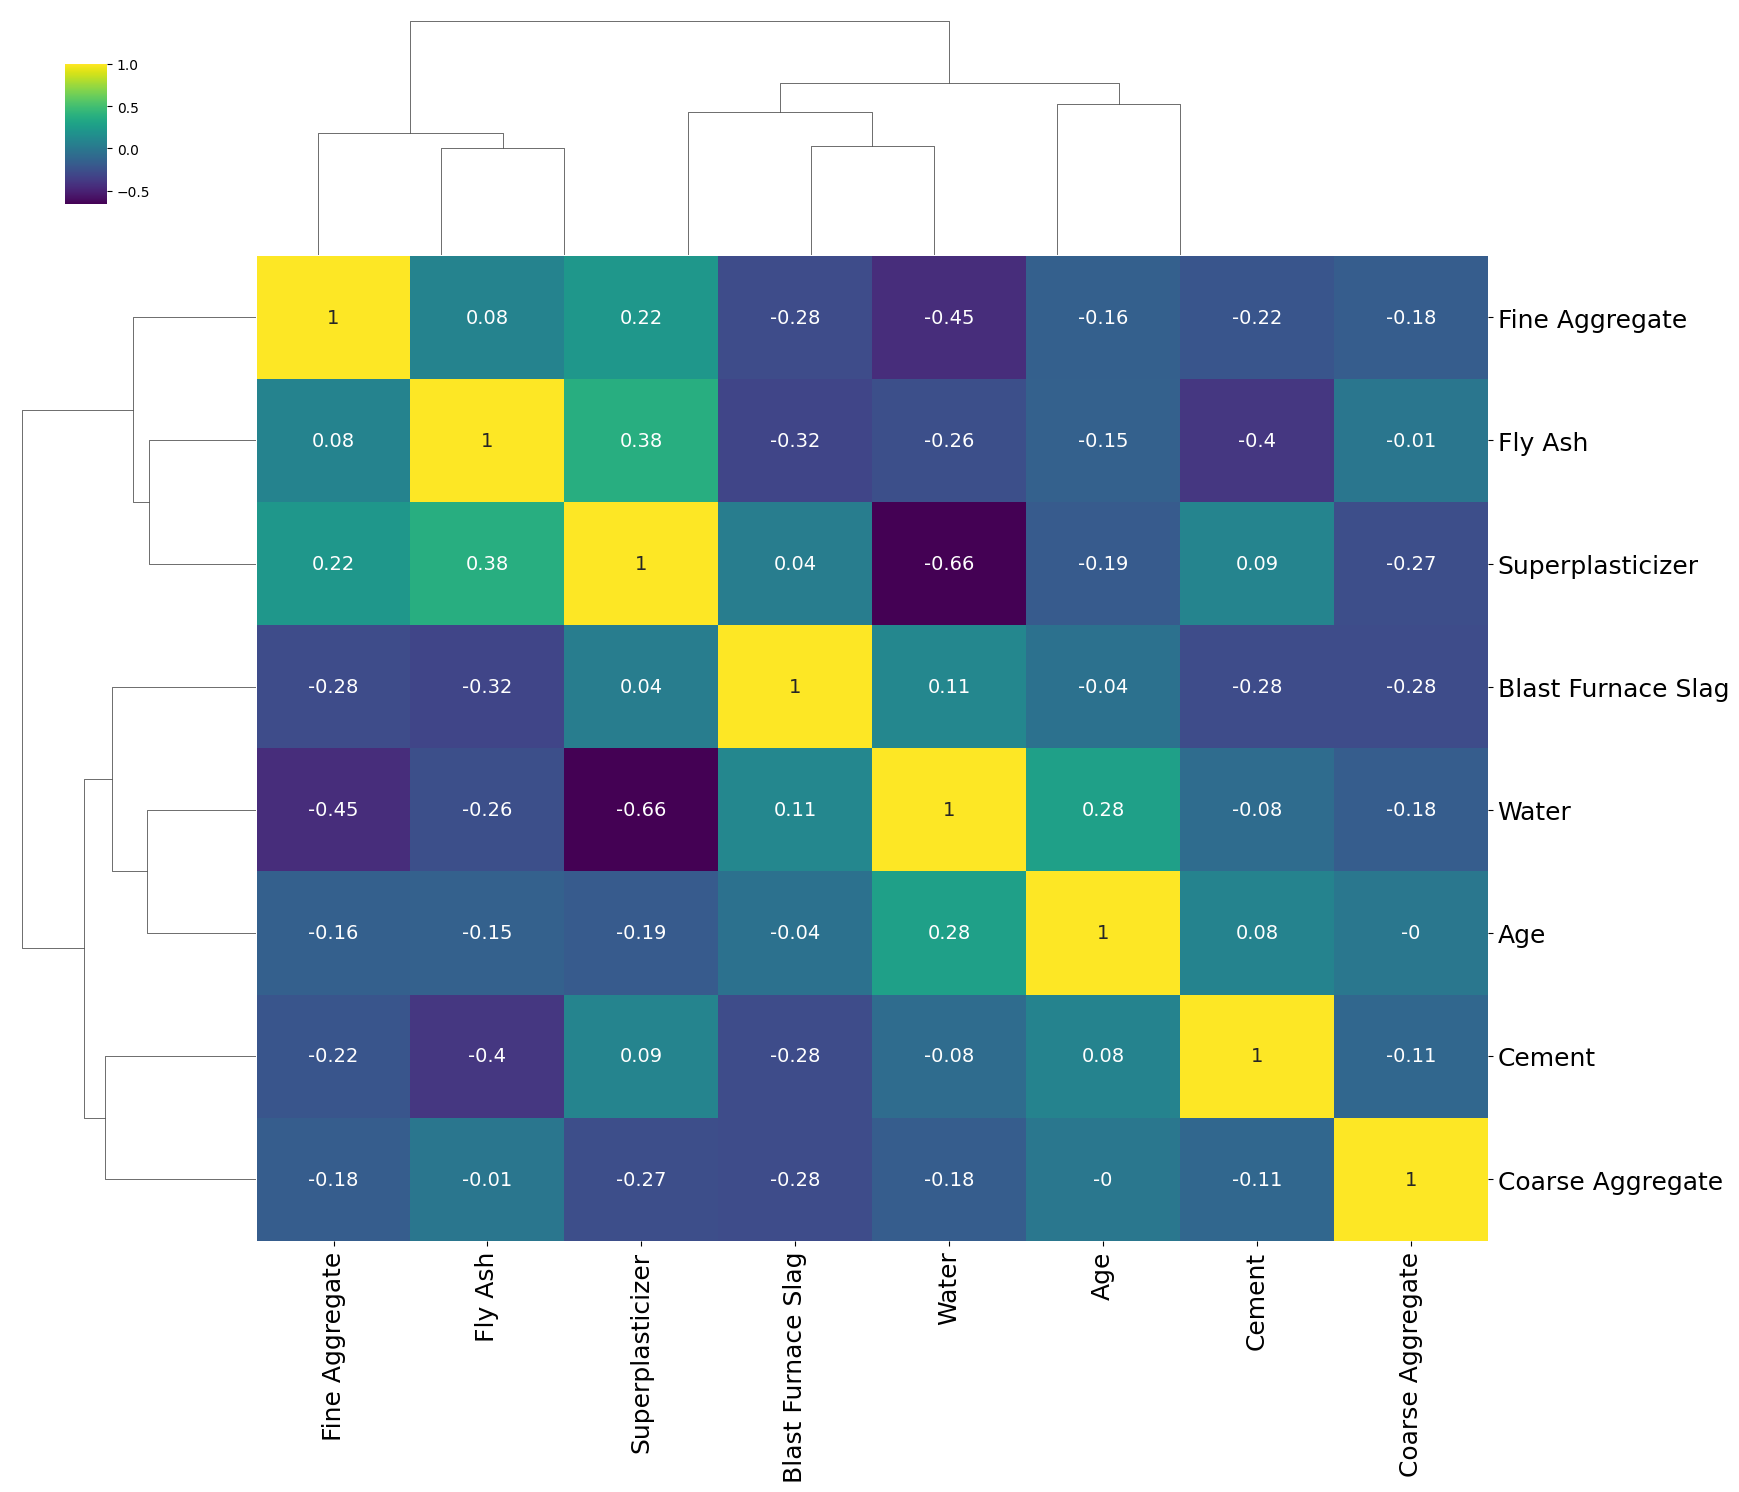

In [4]:
corr = df.drop(columns='Concrete compressive strength').corr()
# corr
# round(corr,2)
g = sns.clustermap(round(corr,2), 
                method = 'complete',
                annot  = True,
                annot_kws = {'size': 14},
                figsize=(14,14), 
                cmap="viridis",
                # round(corr,2),
                )

plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=18,rotation=90)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=18)
hm = g.ax_heatmap.get_position()
g.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*1.25, hm.height])
# col = g.ax_loc_dendrogram.get_position()
# g.ax_loc_dendrogram.set_position([col.x0, col.y0, col.width*1.25, col.height])
g.ax_cbar.set_position((0.05, 0.85, .03, .1))

### Decision Tree

In [5]:

tree_regressor = DecisionTreeRegressor(random_state=42)

parameters = {
    # 'max_depth': [3, 5, 7, 10, 12],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': np.linspace(0, 1, 11)
}

gridtree = GridSearchCV(tree_regressor, parameters, cv=5, n_jobs=-1, verbose=2, 
                          scoring="neg_root_mean_squared_error")

# Assuming you have defined your features X and target y
gridtree.fit( X_train, Y_train)

# After fitting, to get the RMSE for each max_features setting:
results = gridtree.cv_results_
for max_feature in [None, 'sqrt', 'log2']:
    # Extract and print the mean test score (negative RMSE) for each max_feature setting
    mask = results['param_max_features'] == max_feature
    mean_test_score = results['mean_test_score'][mask]
    std_test_score = results['std_test_score'][mask]
    rmse_scores = -mean_test_score  # Convert to positive RMSE
    print(f"Max Features: {max_feature}, RMSE: {np.mean(rmse_scores)}, Std: {np.mean(std_test_score)}")
best_params = gridtree.best_params_
print('Best Parameters: ',best_params)



Fitting 5 folds for each of 33 candidates, totalling 165 fits
Max Features: None, RMSE: 7.594305328878136, Std: 0.418744163410615
Max Features: sqrt, RMSE: 9.633769446939976, Std: 0.9015432444018837
Max Features: log2, RMSE: 8.381080425477245, Std: 0.5773458667395628
Best Parameters:  {'ccp_alpha': 0.0, 'max_features': None}


In [6]:
# Extract the unique ccp_alpha values used during grid search
unique_ccp_alphas = np.unique(gridtree.cv_results_['param_ccp_alpha'].data)#.round(1)

# Initialize a list to keep track of tree depths for each ccp_alpha value
ccp_alpha_depths = []

for ccp_alpha in unique_ccp_alphas:
    # Filter the grid search results for the current ccp_alpha
    mask = gridtree.cv_results_['param_ccp_alpha'] == ccp_alpha
    mean_test_scores = gridtree.cv_results_['mean_test_score'][mask]
    
    # Find the index of the best score for the current ccp_alpha
    best_index = np.argmax(mean_test_scores)
    
    # Extract the best parameters for the current ccp_alpha
    best_params = {param: gridtree.cv_results_[f'param_{param}'][mask][best_index] for param in parameters}
    
    # Create and fit a new model with these parameters to find its depth
    tree = DecisionTreeRegressor(**best_params, random_state=42)
    tree.fit(X_train, Y_train)
    
    # Record the ccp_alpha and the corresponding tree depth
    ccp_alpha_depths.append((ccp_alpha, tree.get_depth()))

# Print the depths for each ccp_alpha
print("ccp_alpha and corresponding tree depths:")
for ccp_alpha, depth in ccp_alpha_depths:
    print(f"ccp_alpha={ccp_alpha}: Depth={depth}")

# Identify and print the best ccp_alpha value and its depth
best_ccp_alpha = gridtree.best_params_['ccp_alpha']
best_depth = [depth for alpha, depth in ccp_alpha_depths if alpha == best_ccp_alpha][0]
print(f"\nBest ccp_alpha: {best_ccp_alpha} with a tree depth of: {best_depth}")


ccp_alpha and corresponding tree depths:
ccp_alpha=0.0: Depth=20
ccp_alpha=0.1: Depth=11
ccp_alpha=0.2: Depth=10
ccp_alpha=0.30000000000000004: Depth=9
ccp_alpha=0.4: Depth=9
ccp_alpha=0.5: Depth=8
ccp_alpha=0.6000000000000001: Depth=7
ccp_alpha=0.7000000000000001: Depth=7
ccp_alpha=0.8: Depth=7
ccp_alpha=0.9: Depth=7
ccp_alpha=1.0: Depth=7

Best ccp_alpha: 0.0 with a tree depth of: 20


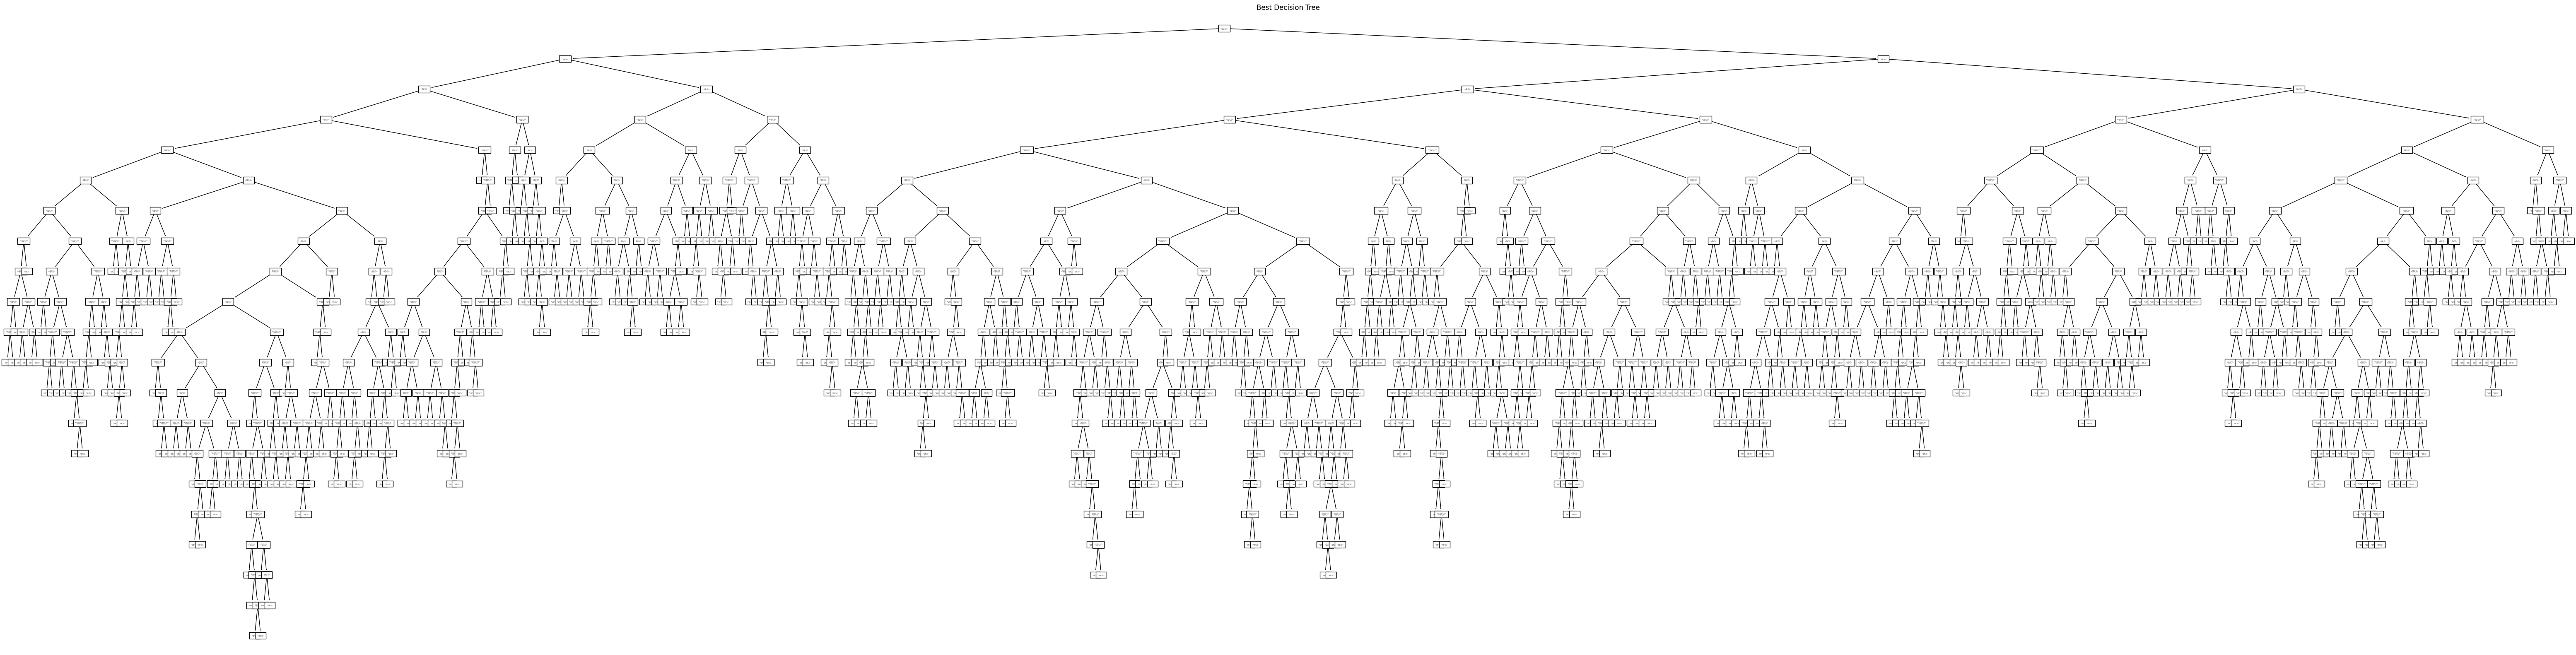

In [9]:

best_tree = gridtree.best_estimator_

plt.figure(figsize=(80, 20))
plot_tree(best_tree, filled=False, feature_names=X_train.columns, precision=2, fontsize= 1, proportion=True)
plt.title("Best Decision Tree")
plt.savefig("Best_Decision_Tree_plot.png", dpi=400, format='png', bbox_inches='tight')

plt.show()

feature_importances = best_tree.feature_importances_
importance_dict = {name: importance for name, importance in zip(X_train.columns, feature_importances)}
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)




Fitting 5 folds for each of 33 candidates, totalling 165 fits


Fitting 5 folds for each of 33 candidates, totalling 165 fits
********* RMSE Results *********
RMSE (test): 7.4195
RMSE (train): 1.1119
RMSE (total): 3.464
*********************************
********* R Squared Results *****
R Squared (test): 0.791
R Squared (train): 0.9956
R Squared (total): 0.957
*********************************
*********************************


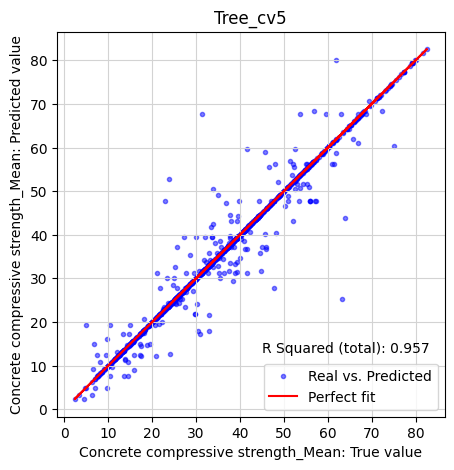

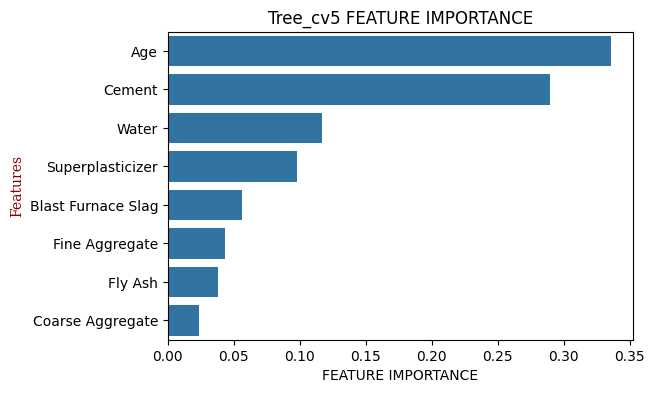

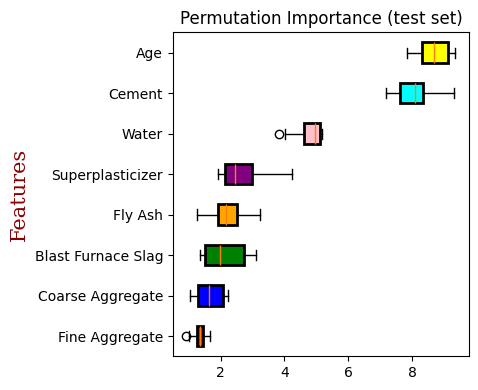

Computing partial dependence plots...
Feature Importances:
Age: 0.3355
Cement: 0.2894
Water: 0.1169
Superplasticizer: 0.0976
Blast Furnace Slag: 0.0560
Fine Aggregate: 0.0429
Fly Ash: 0.0382
Coarse Aggregate: 0.0235

Most Important Variable: Age
Root Node Feature: Age


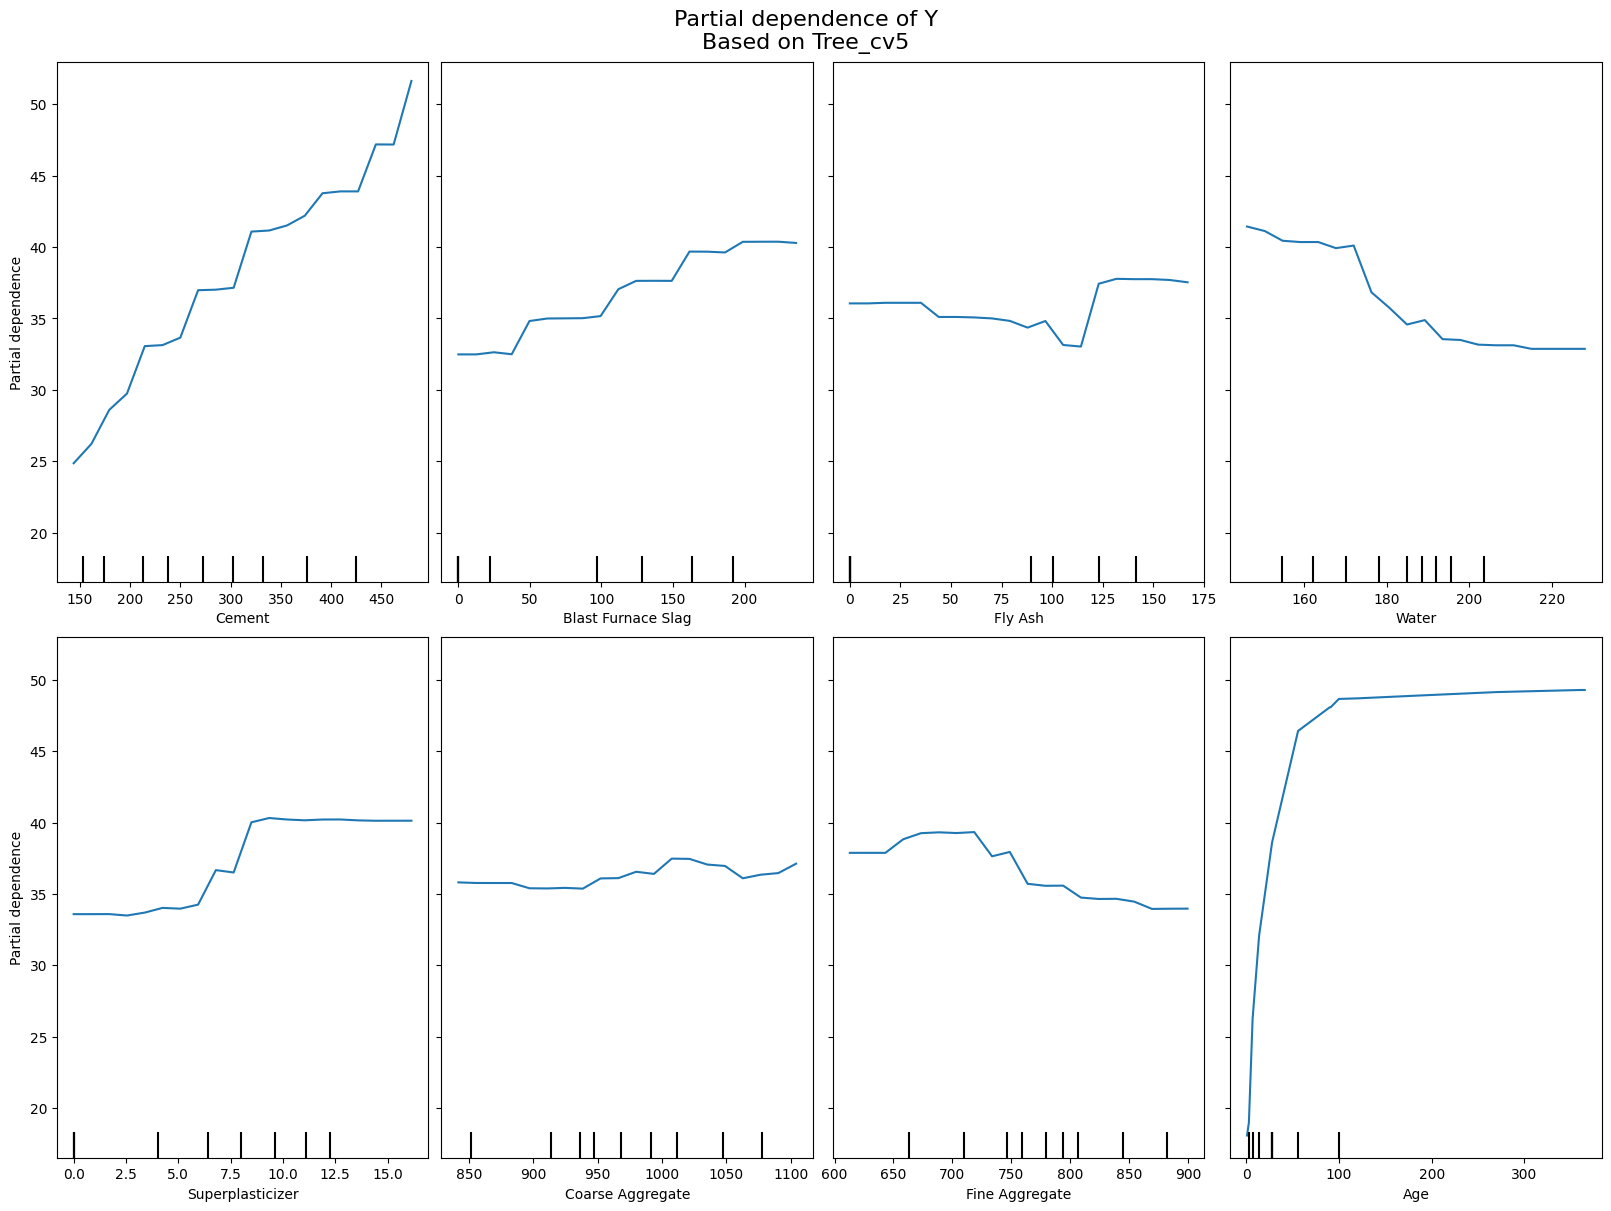

In [24]:
model = gridtree
model_name= 'Tree_cv5'
ML_results(model, X, Y, X_train, Y_train, X_test, Y_test, model_name)
plot_feature_importance(X, model, model_name, figsize=(6,4))
plot_permutation_feature_importance(X, Y, model, model_name, n_repeats=10, figsize=(8,4))
feature_list = X.columns
ncols=4
nrows=2
partial_dependency_func(X, Y, model, model_name, feature_list, ncols, nrows, figsize=(16, 12), fontsize=16)

print("Feature Importances:")
for name, importance in sorted_importances:
    print(f"{name}: {importance:.4f}")

# Identifying the most important variable and the root node
most_important_feature = sorted_importances[0][0]
print(f"\nMost Important Variable: {most_important_feature}")
print(f"Root Node Feature: {most_important_feature}")

### Random Forest

In [25]:

regr = RandomForestRegressor(random_state=0)

parameters = {
    # 'max_depth': [3, 5, 7, 10, 12],
    'n_estimators': [20, 50, 100],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': np.linspace(0, 1, 11)
}




# Update scoring to negative RMSE
gridforest = GridSearchCV(regr, parameters, cv=5, n_jobs=-1, verbose=2, 
                          scoring="neg_root_mean_squared_error")

# Assuming you have defined your features X and target y
gridforest.fit( X_train, Y_train)

# After fitting, to get the RMSE for each max_features setting:
results = gridforest.cv_results_
for max_feature in [None, 'sqrt', 'log2']:
    # Extract and print the mean test score (negative RMSE) for each max_feature setting
    mask = results['param_max_features'] == max_feature
    mean_test_score = results['mean_test_score'][mask]
    std_test_score = results['std_test_score'][mask]
    rmse_scores = -mean_test_score  # Convert to positive RMSE
    print(f"Max Features: {max_feature}, RMSE: {np.mean(rmse_scores)}, Std: {np.mean(std_test_score)}")
best_params = gridforest.best_params_
print('Best Parameters: ',best_params)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
Max Features: None, RMSE: 6.118473767101241, Std: 0.47898521375684666
Max Features: sqrt, RMSE: 6.497609568550314, Std: 0.3696547252026138
Max Features: log2, RMSE: 6.1181406231635105, Std: 0.33135491000892325
Best Parameters:  {'ccp_alpha': 0.0, 'max_features': 'log2', 'n_estimators': 100}


Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
********* RMSE Results *********
RMSE (test): 4.5368
RMSE (train): 2.0817
RMSE (total): 2.7538
*********************************
********* R Squared Results *****
R Squared (test): 0.9219
R Squared (train): 0.9846
R Squared (total): 0.9728
*********************************
*********************************


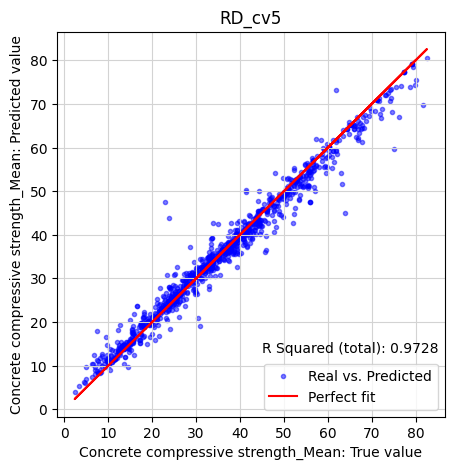

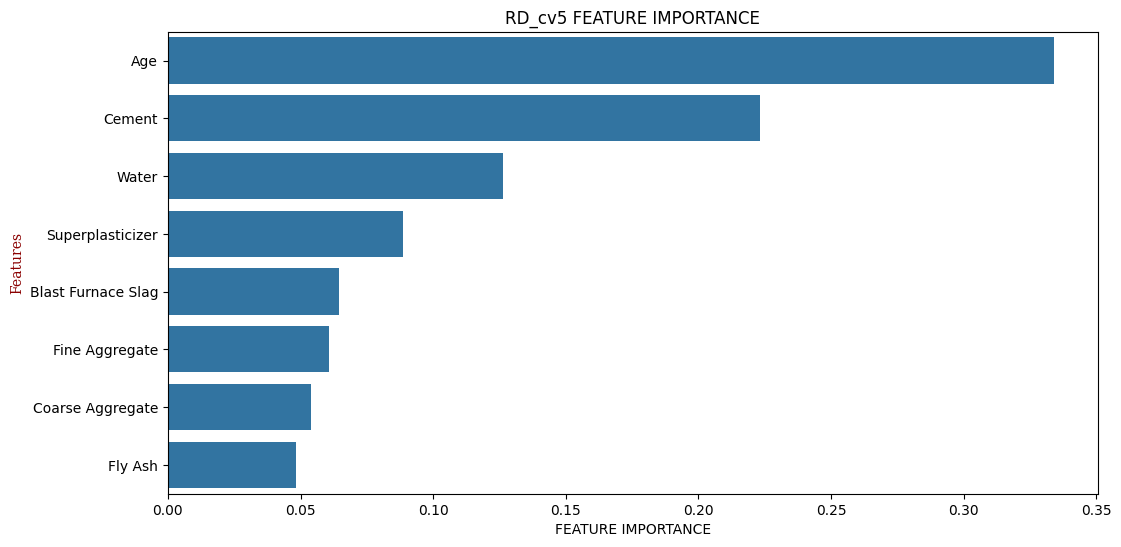

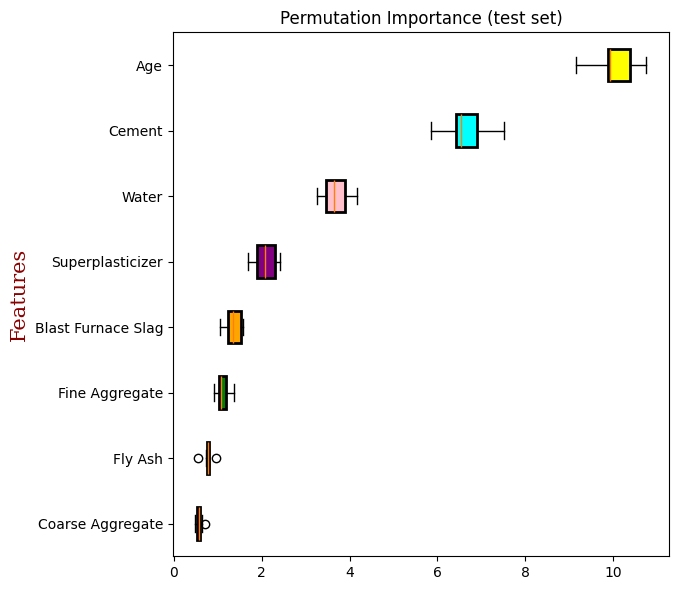

Computing partial dependence plots...


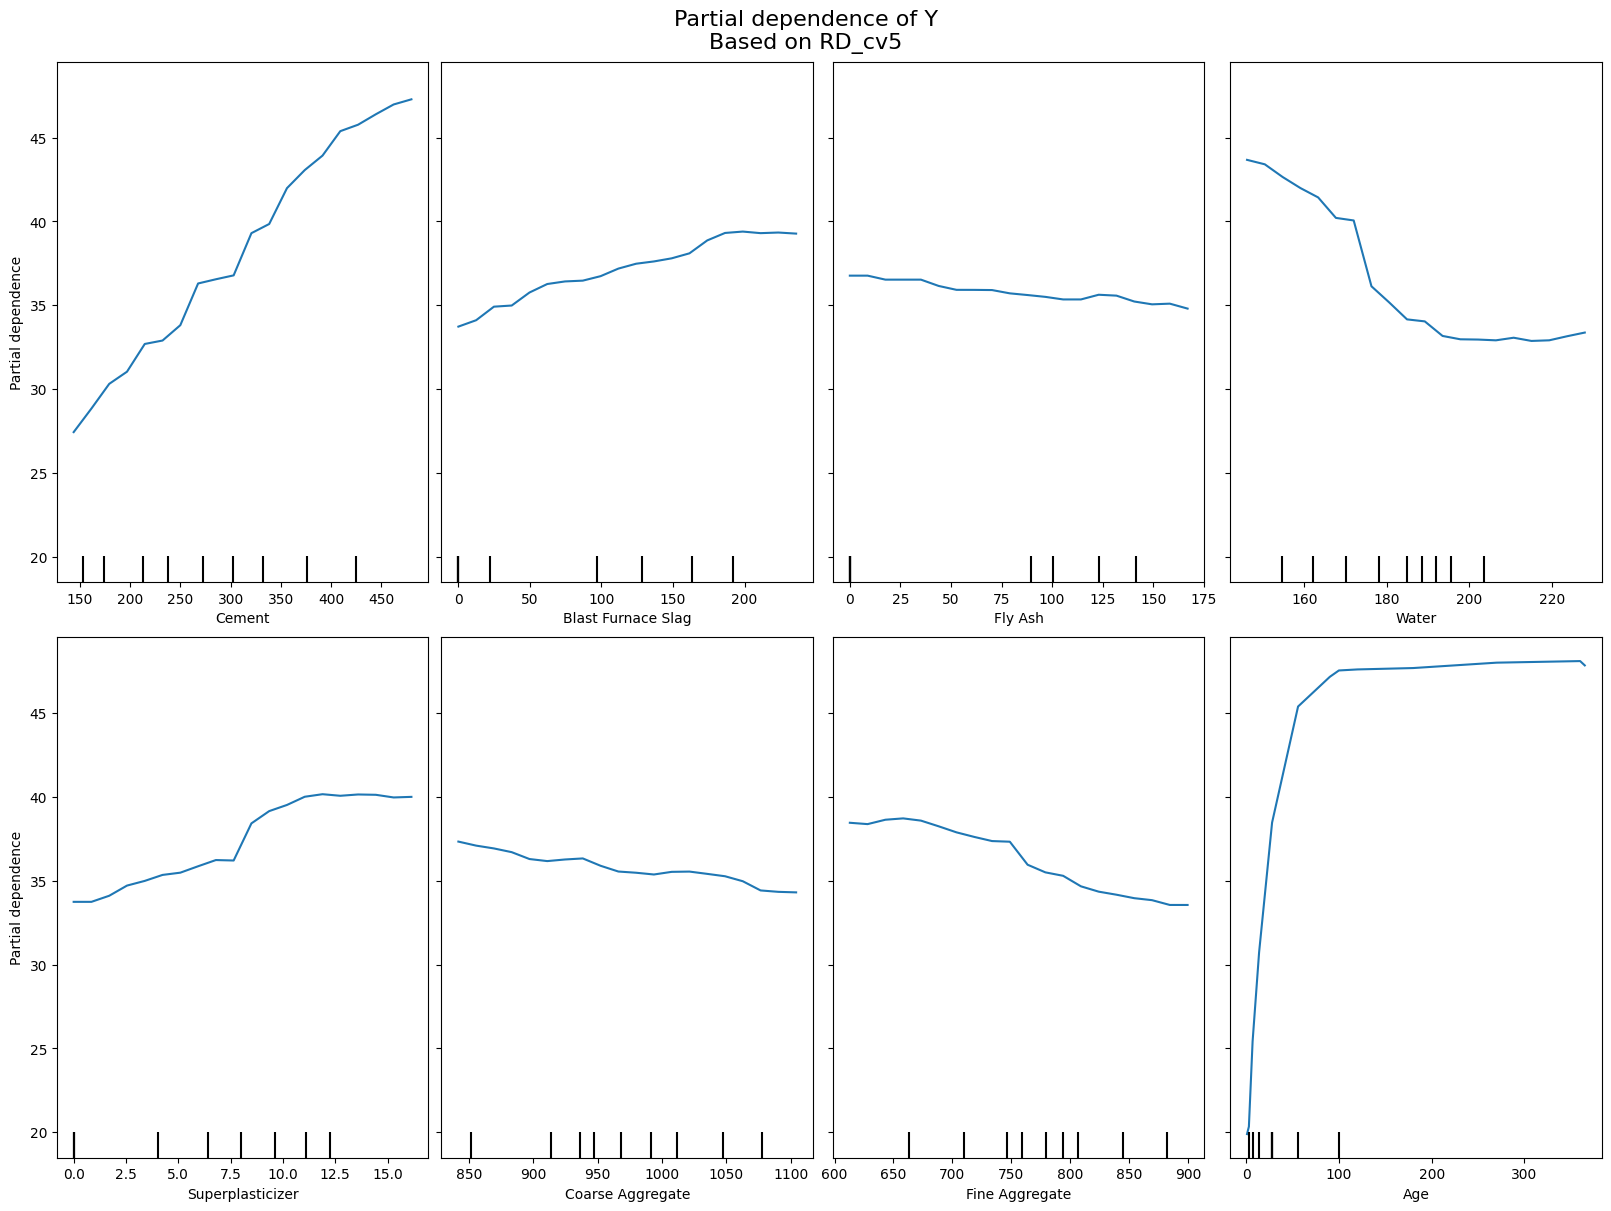

In [26]:
model = gridforest
model_name= 'RD_cv5'
ML_results(model, X, Y, X_train, Y_train, X_test, Y_test, model_name)
plot_feature_importance(X, model, model_name, figsize=(12,6))
plot_permutation_feature_importance(X, Y, model, model_name, n_repeats=10, figsize=(12,6))
partial_dependency_func(X, Y, model, model_name, feature_list, ncols, nrows, figsize=(16, 12), fontsize=16)

## Gradient Boosting

In [27]:
parameters = {
    # 'max_depth': [3, 5, 7, 10, 12],
    'n_estimators': [20, 50, 100],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': np.linspace(0, 1, 11)
}

gradboot =GradientBoostingRegressor(random_state=0)

gridboost = GridSearchCV(gradboot, parameters, cv=5, n_jobs=-1, verbose=2, 
                          scoring="neg_root_mean_squared_error")


# Assuming you have defined your features X and target y
gridboost.fit( X_train, Y_train)

# After fitting, to get the RMSE for each max_features setting:
results = gridboost.cv_results_
for max_feature in [None, 'sqrt', 'log2']:
    # Extract and print the mean test score (negative RMSE) for each max_feature setting
    mask = results['param_max_features'] == max_feature
    mean_test_score = results['mean_test_score'][mask]
    std_test_score = results['std_test_score'][mask]
    rmse_scores = -mean_test_score  # Convert to positive RMSE
    print(f"Max Features: {max_feature}, RMSE: {np.mean(rmse_scores)}, Std: {np.mean(std_test_score)}")
best_params = gridboost.best_params_
print('Best Parameters: ',best_params)




Fitting 5 folds for each of 99 candidates, totalling 495 fits
Max Features: None, RMSE: 6.861573276794314, Std: 0.25277344946030184
Max Features: sqrt, RMSE: 7.225481353540505, Std: 0.329837735255515
Max Features: log2, RMSE: 6.896418487986799, Std: 0.2522315436197714
Best Parameters:  {'ccp_alpha': 0.0, 'max_features': 'log2', 'n_estimators': 100}


Fitting 5 folds for each of 99 candidates, totalling 495 fits


Fitting 5 folds for each of 99 candidates, totalling 495 fits
********* RMSE Results *********
RMSE (test): 4.8484
RMSE (train): 3.7631
RMSE (total): 4.0037
*********************************
********* R Squared Results *****
R Squared (test): 0.9107
R Squared (train): 0.9498
R Squared (total): 0.9425
*********************************
*********************************


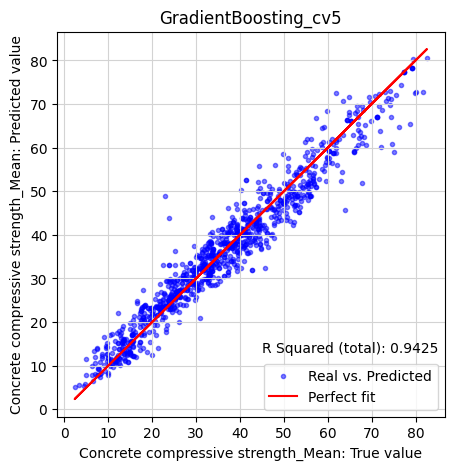

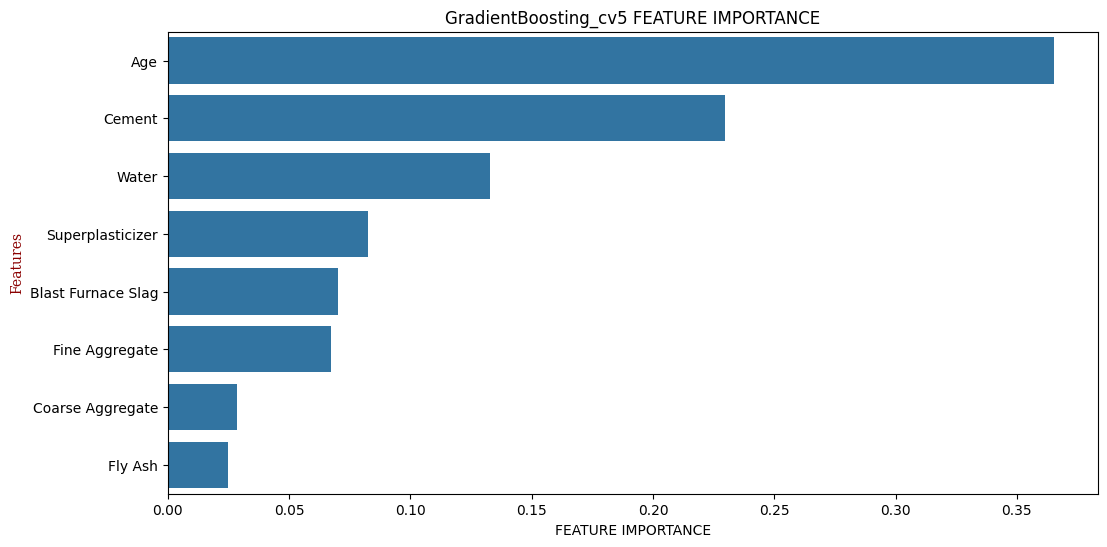

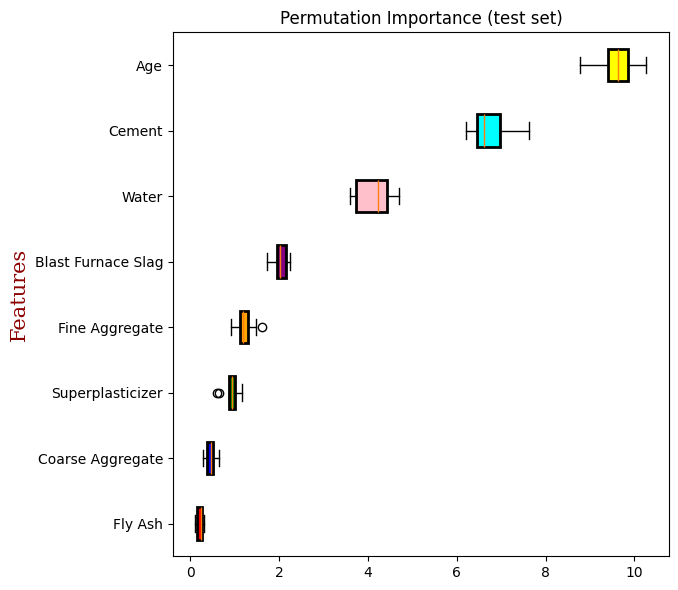

Computing partial dependence plots...


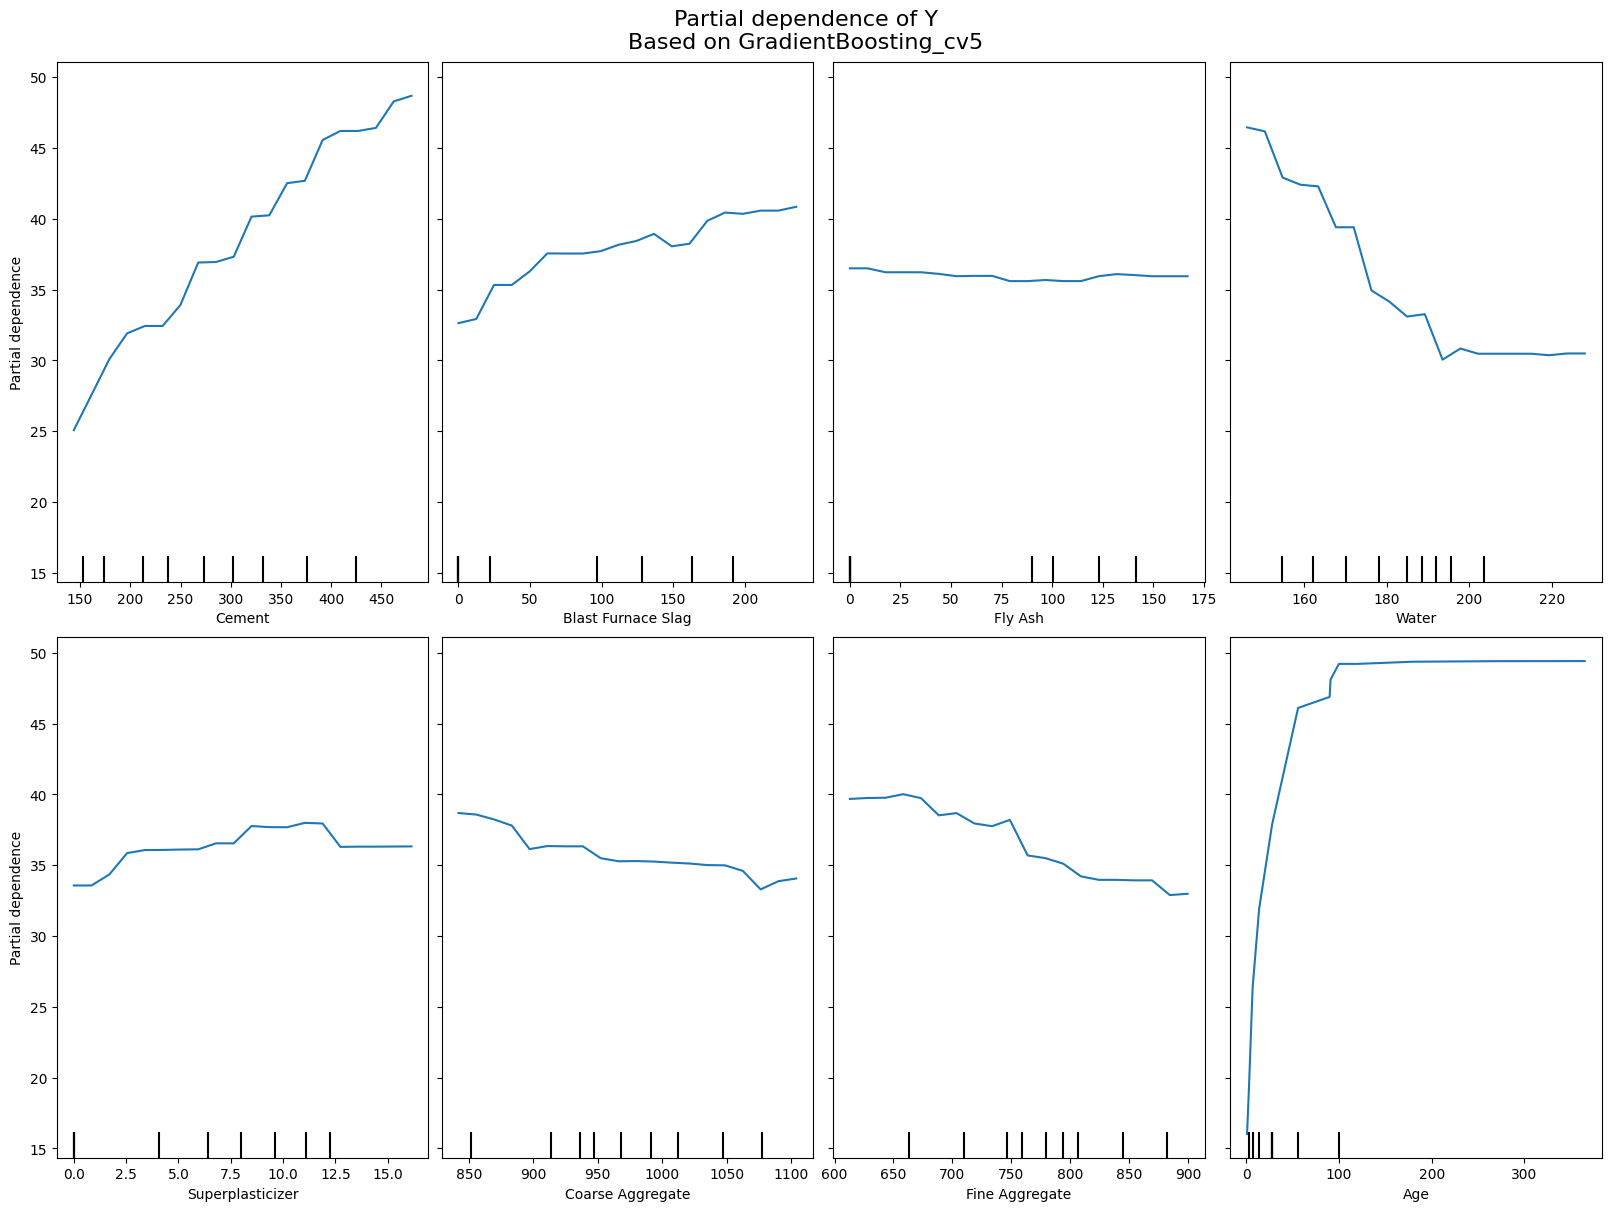

In [28]:

model = gridboost
model_name= 'GradientBoosting_cv5'
ML_results(model, X, Y, X_train, Y_train, X_test, Y_test, model_name)
plot_feature_importance(X, model, model_name, figsize=(12,6))
plot_permutation_feature_importance(X, Y, model, model_name, n_repeats=10, figsize=(12,6))
partial_dependency_func(X, Y, model, model_name, feature_list, ncols, nrows, figsize=(16, 12), fontsize=16)